# covid19pt-forecasting

Blablabla

## Imports

In [4]:
import pandas as pd
import requests
import json

## Import data from DGS API

### API

In [5]:
response = requests.get("https://covid19-api.vost.pt/Requests/get_full_dataset")

In [6]:
data_dgs = response.json()

In [7]:
data_dgs_df = pd.DataFrame.from_dict(data_dgs)
data_dgs_df['data_dados'] = pd.to_datetime(data_dgs_df.data_dados, infer_datetime_format=True)
data_dgs_df = data_dgs_df.set_index('data_dados').sort_index()


In [8]:
display(data_dgs_df)

,data,confirmados,confirmados_arsnorte,confirmados_arscentro,confirmados_arslvt,confirmados_arsalentejo,confirmados_arsalgarve,confirmados_acores,confirmados_madeira,confirmados_estrangeiro,...,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,confirmados_desconhecidos_m,confirmados_desconhecidos_f,ativos,internados_enfermaria,confirmados_desconhecidos
data_dados,,,,,,,,,,,,,,,,,,,,,
2020-02-26,26-02-2020,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-27,27-02-2020,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-28,28-02-2020,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,29-02-2020,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,01-03-2020,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-26,26-01-2021,653878,289212,91764,227893,22724,15529,3284,3472,NaN,...,1428.0,4049.0,3360.0,5271.0,5741.0,NaN,NaN,167381.0,5707.0,200.0
2021-01-27,27-01-2021,668951,293171,94073,235498,23208,16029,3309,3663,NaN,...,1469.0,4136.0,3464.0,5404.0,5901.0,NaN,NaN,172893.0,5820.0,203.0
2021-01-28,28-01-2021,685383,297228,96809,244119,23737,16356,3376,3758,NaN,...,1504.0,4242.0,3567.0,5547.0,6061.0,NaN,NaN,180076.0,5783.0,210.0


# Confirmed cases only

In [9]:
data_dgs_df_confirmed = data_dgs_df[['confirmados']]
# add missing days
all_days = pd.date_range(data_dgs_df_confirmed.index.min(), data_dgs_df_confirmed.index.max(), freq='D')
data_dgs_df_confirmed.reindex(all_days)

#data_dgs_df_confirmed = data_dgs_df_confirmed[data_dgs_df_confirmed['confirmados'] != 0] # drop days without information
display(data_dgs_df_confirmed)

,confirmados
data_dados,
2020-02-26,0
2020-02-27,0
2020-02-28,0
2020-02-29,0
2020-03-01,0
...,...
2021-01-26,653878
2021-01-27,668951
2021-01-28,685383


## Timeseries magic

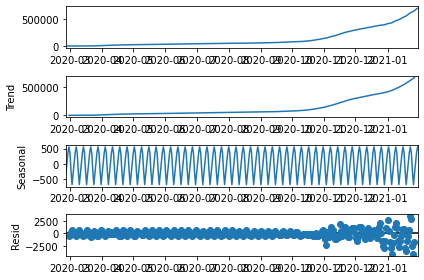

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

data_dgs_df_confirmed = data_dgs_df_confirmed.asfreq('d')
data_dgs_df_confirmed = data_dgs_df_confirmed.fillna(method='bfill').fillna(method='ffill')

decomposition = seasonal_decompose(data_dgs_df_confirmed,  model='additive') #period = 30 WHAT DOES PERIOD DO?
decomposition.plot()
plt.show() 

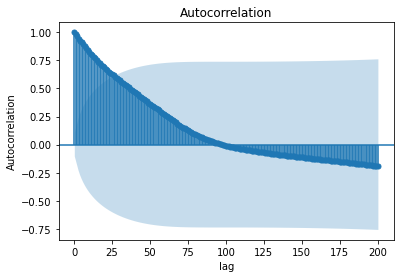

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_dgs_df_confirmed, alpha=0.05, lags=200)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

### Make data stationary

In [12]:
data_dgs_df_confirmed_detrend = data_dgs_df_confirmed.diff().dropna()

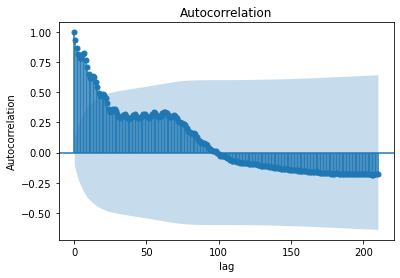

In [13]:
plot_acf(data_dgs_df_confirmed_detrend, alpha=0.05, lags=210)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

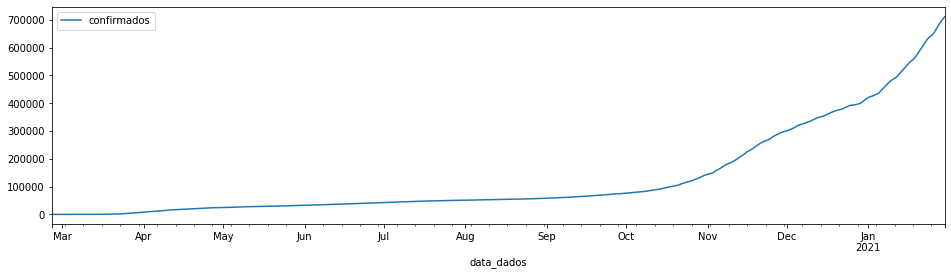

In [14]:
data_dgs_df_confirmed.plot(figsize=(16, 4));

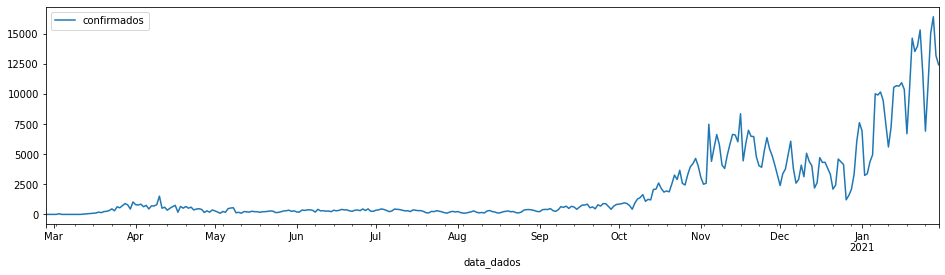

In [15]:
data_dgs_df_confirmed_detrend.plot(figsize=(16, 4));

In [16]:
import pmdarima as pm

sarimax = pm.AutoARIMA(seasonal=True, trace=True, supress_warnings=True, method='nm', maxiter=100, S=7)
sarimax.fit(data_dgs_df_confirmed_detrend, supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5635.711, Time=0.17 sec


/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5631.408, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5633.359, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5633.292, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5629.867, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5595.038, Time=0.14 sec


/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5553.468, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5603.466, Time=0.15 sec


/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5566.803, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5639.091, Time=0.15 sec


/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5590.534, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5710.260, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5556.319, Time=0.20 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.804 seconds


/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


AutoARIMA(maxiter=100, method='nm', trace=True)

/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/pmdarima/arima/arima.py:560: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


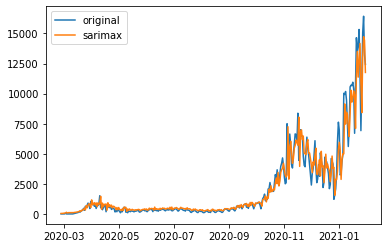

In [17]:
plt.plot(data_dgs_df_confirmed_detrend, label='original')
plt.plot(data_dgs_df_confirmed_detrend.index, sarimax.predict_in_sample(), label='sarimax')
plt.legend()

In [18]:
from sklearn.metrics import mean_absolute_error

predictions = sarimax.predict_in_sample()
mae = mean_absolute_error(predictions, data_dgs_df_confirmed_detrend)

/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/pmdarima/arima/arima.py:560: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


In [19]:
mae

456.14385697102244

In [20]:
import numpy as np

sarimax_forecast_one_step_refit = []
# forecast next 60 days
for i in np.arange(0,120):
    next_step_forecast = sarimax.predict(1)[0]
    sarimax_forecast_one_step_refit.append(next_step_forecast)
    sarimax = sarimax.update(data_dgs_df_confirmed_detrend[i:i+1])

/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/hom

/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/hom

/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/hom

/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/cimendes/miniconda3/envs/hack03/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/hom

<AxesSubplot:>

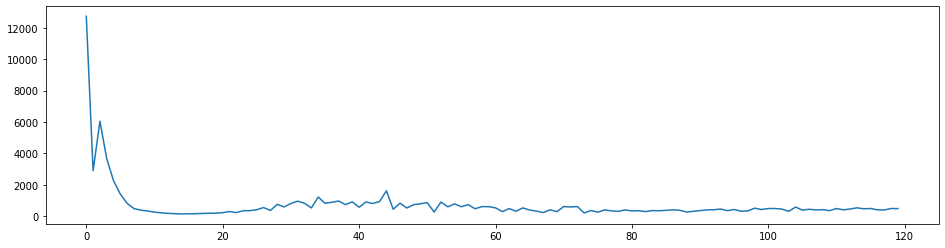

In [25]:
pd.Series(sarimax_forecast_one_step_refit).plot(figsize=(16, 4))

<AxesSubplot:>

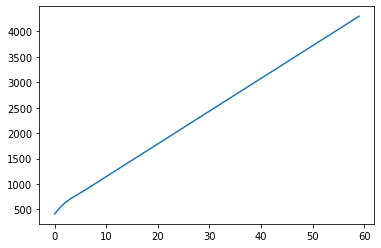

In [19]:
forecast = sarimax.predict(60)
pd.Series(forecast).plot()
